# Is there a causal link between a wine's numeric and categorical variables?
### Goal: Peform ANOVA and Tukey's Test, and Causal Inference techniques to determine if two variables differ significantly from one another. The variables in question are geographical location where the wine was made, it's type (red, white, etc.), and its price and WineEnthusiast rating.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, kruskal, skew
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
import pingouin as pg
import scikit_posthocs as sp
from itertools import product
%matplotlib inline 

In [83]:
wines = pd.read_csv('wines.csv')
wines.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


## Data Cleaning/Wrangling and Exploratory Data Analysis

In [84]:
wines = pd.read_csv('wines.csv')
wines.drop(columns = ['Unnamed: 0', 'description'], inplace = True)
wines.head()

,country,designation,points,price,province,region_1,region_2,variety,winery
0,US,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [85]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   designation  105195 non-null  object 
 2   points       150930 non-null  int64  
 3   price        137235 non-null  float64
 4   province     150925 non-null  object 
 5   region_1     125870 non-null  object 
 6   region_2     60953 non-null   object 
 7   variety      150930 non-null  object 
 8   winery       150930 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 10.4+ MB


In [86]:
print(wines['variety'].unique())

['Cabernet Sauvignon' 'Tinta de Toro' 'Sauvignon Blanc' 'Pinot Noir'
 'Provence red blend' 'Friulano' 'Tannat' 'Chardonnay' 'Tempranillo'
 'Malbec' 'Rosé' 'Tempranillo Blend' 'Syrah' 'Mavrud' 'Sangiovese'
 'Sparkling Blend' 'Rhône-style White Blend' 'Red Blend' 'Mencía'
 'Palomino' 'Petite Sirah' 'Riesling' 'Cabernet Sauvignon-Syrah'
 'Portuguese Red' 'Nebbiolo' 'Pinot Gris' 'Meritage' 'Baga' 'Glera'
 'Malbec-Merlot' 'Merlot-Malbec' 'Ugni Blanc-Colombard' 'Viognier'
 'Cabernet Sauvignon-Cabernet Franc' 'Moscato' 'Pinot Grigio'
 'Cabernet Franc' 'White Blend' 'Monastrell' 'Gamay' 'Zinfandel' 'Greco'
 'Barbera' 'Grenache' 'Rhône-style Red Blend' 'Albariño' 'Malvasia Bianca'
 'Assyrtiko' 'Malagouzia' 'Carmenère' 'Bordeaux-style Red Blend'
 'Touriga Nacional' 'Agiorgitiko' 'Picpoul' 'Godello' 'Gewürztraminer'
 'Merlot' 'Syrah-Grenache' 'G-S-M' 'Mourvèdre'
 'Bordeaux-style White Blend' 'Petit Verdot' 'Muscat'
 'Chenin Blanc-Chardonnay' 'Cabernet Sauvignon-Merlot' 'Pinot Bianco'
 'Alvarinho'

In [87]:
wine_type_mapping = {
    'Cabernet Sauvignon': 'Red','Tinta de Toro': 'Red','Sauvignon Blanc': 'White',
    'Pinot Noir': 'Red','Provence red blend': 'Red','Friulano': 'White',
    'Tannat': 'Red','Chardonnay': 'White','Tempranillo': 'Red','Malbec': 'Red',
    'Rosé': 'Rosé','Tempranillo Blend': 'Red','Syrah': 'Red','Mavrud': 'Red',
    'Sangiovese': 'Red','Sparkling Blend': 'Sparkling','Rhône-style White Blend': 'White',
    'Red Blend': 'Red','Mencía': 'Red','Palomino': 'White','Petite Sirah': 'Red',
    'Riesling': 'White','Cabernet Sauvignon-Syrah': 'Red','Portuguese Red': 'Red',
    'Nebbiolo': 'Red','Pinot Gris': 'White','Meritage': 'Red','Baga': 'Red',
    'Glera': 'White','Malbec-Merlot': 'Red','Merlot-Malbec': 'Red','Ugni Blanc-Colombard': 'White',
    'Viognier': 'White','Cabernet Sauvignon-Cabernet Franc': 'Red','Moscato': 'White',
    'Pinot Grigio': 'White','Cabernet Franc': 'Red','White Blend': 'White',
    'Monastrell': 'Red','Gamay': 'Red','Zinfandel': 'Red','Greco': 'White',
    'Barbera': 'Red','Grenache': 'Red','Rhône-style Red Blend': 'Red','Albariño': 'White',
    'Malvasia Bianca': 'White','Assyrtiko': 'White','Malagouzia': 'White',
    'Carmenère': 'Red','Bordeaux-style Red Blend': 'Red','Touriga Nacional': 'Red',
    'Agiorgitiko': 'Red','Picpoul': 'White','Godello': 'White','Gewürztraminer': 'White',
    'Merlot': 'Red','Syrah-Grenache': 'Red','G-S-M': 'Red','Mourvèdre': 'Red',
    'Bordeaux-style White Blend': 'White','Petit Verdot': 'Red','Muscat': 'White',
    'Chenin Blanc-Chardonnay': 'White','Cabernet Sauvignon-Merlot': 'Red','Pinot Bianco': 'White',
    'Alvarinho': 'White','Portuguese White': 'White','Garganega': 'White','Sauvignon': 'White',
    'Gros and Petit Manseng': 'White','Tannat-Cabernet': 'Red','Alicante Bouschet': 'Red',
    'Aragonês': 'Red','Silvaner': 'White','Ugni Blanc': 'White','Grüner Veltliner': 'White',
    'Frappato': 'Red','Lemberger': 'Red','Sylvaner': 'White','Chasselas': 'White',
    'Alsace white blend': 'White','Früburgunder': 'Red','Kekfrankos': 'Red','Vermentino': 'White',
    'Sherry': 'Fortified','Aglianico': 'Red','Torrontés': 'White','Primitivo': 'Red',
    'Semillon-Sauvignon Blanc': 'White','Portuguese Rosé': 'Rosé','Grenache-Syrah': 'Red',
    'Prié Blanc': 'White','Negrette': 'Red','Furmint': 'White','Carignane': 'Red',
    'Pinot Blanc': 'White',"Nero d'Avola": 'Red','St. Laurent': 'Red','Blauburgunder': 'Red',
    'Blaufränkisch': 'Red','Scheurebe': 'White','Ribolla Gialla': 'White','Charbono': 'Red',
    'Malbec-Cabernet Sauvignon': 'Red','Pinot Noir-Gamay': 'Red','Pinot Nero': 'Red',
    'Gros Manseng': 'White','Nerello Mascalese': 'Red','Shiraz': 'Red','Negroamaro': 'Red',
    'Champagne Blend': 'Sparkling','Romorantin': 'White','Syrah-Cabernet Sauvignon': 'Red',
    'Tannat-Merlot': 'Red','Duras': 'Red','Garnacha': 'Red','Tinta Francisca': 'Red',
    'Portuguese Sparkling': 'Sparkling','Chenin Blanc': 'White','Turbiana': 'White',
    'Petite Verdot': 'Red','Posip': 'White','Fumé Blanc': 'White','Roussanne': 'White',
    'Grillo': 'White','Müller-Thurgau': 'White','Pinot Auxerrois': 'White','Port': 'Fortified',
    'Cabernet Blend': 'Red','Cabernet Franc-Cabernet Sauvignon': 'Red','Castelão': 'Red',
    'Encruzado': 'White','Touriga Nacional-Cabernet Sauvignon': 'Red',
    'Colombard-Sauvignon Blanc': 'White','Moscatel': 'White','Marsanne': 'White',
    'Siria': 'White','Garnacha Blanca': 'White','Merlot-Cabernet Sauvignon': 'Red',
    'Arinto': 'White','Petit Manseng': 'White','Loureiro': 'White','Melon': 'White',
    'Carricante': 'White','Fiano': 'White','Schwartzriesling': 'White','Sangiovese-Syrah': 'Red',
    'Tannat-Cabernet Franc': 'Red','Cabernet Franc-Merlot': 'Red','Sauvignon Blanc-Semillon': 'White',
    'Macabeo': 'White','Alfrocheiro': 'Red','Aligoté': 'White','Verdejo': 'White',
    'Grenache Blanc': 'White','Fernão Pires': 'White','Spätburgunder': 'Red','Ciliegiolo': 'Red',
    'Cabernet Sauvignon-Carmenère': 'Red','Auxerrois': 'White','Sirica': 'Red','Zweigelt': 'Red',
    'Pugnitello': 'Red','Rosado': 'Rosé','Rosato': 'Rosé','Malvazija': 'White','Kalecik Karasi': 'Red',
    'Muskat Ottonel': 'White','Malbec-Bonarda': 'Red','Tempranillo-Cabernet Sauvignon': 'Red',
    'Rivaner': 'White','Trepat': 'Red','Baco Noir': 'Red','Trebbiano': 'White',
    'Chardonnay-Viognier': 'White','Syrah-Mourvèdre': 'Red','Graciano': 'Red','Roviello': 'Red',
    'Perricone': 'Red','Falanghina': 'White','Vranec': 'Red','Carignan': 'Red',
    'Cabernet-Shiraz': 'Red','Verdelho': 'White','Pedro Ximénez': 'Fortified',
    'Marsanne-Roussanne': 'White','Malbec Blend': 'Red','Weissburgunder': 'White',
    'Morava': 'Red','Ruen': 'Red','Hondarrabi Zuri': 'White','Catarratto': 'White',
    'Chardonnay-Sauvignon Blanc': 'White','Vidal': 'White','Rieslaner': 'White','Dornfelder': 'Red',
    'Tinto Fino': 'Red','Gelber Muskateller': 'White','Roter Veltliner': 'White','Aragonez': 'Red',
    'Vitovska': 'White','Pinot Noir-Syrah': 'Red','Gamay Noir': 'Red','Grauburgunder': 'White',
    'Cannonau': 'Red','Mauzac': 'White','Austrian Red Blend': 'Red','Sémillon': 'White',
    'Lambrusco di Sorbara': 'Red','Teran': 'Red','Dolcetto': 'Red','Cinsault': 'Red',
    'Assyrtico': 'White','Teroldego': 'Red','Tamjanika': 'White','Boğazkere': 'Red',
    'Kadarka': 'Red','Narince': 'White','Malbec-Petit Verdot': 'Red','Veltliner': 'White',
    'Traminer': 'White','Lambrusco': 'Red','Arneis': 'White','Cabernet Sauvignon-Shiraz': 'Red',
    'Tocai Friulano': 'White','Fer Servadou': 'Red','Muskateller': 'White','Nerello Cappuccio': 'Red',
    'Moscatel Roxo': 'White','Elbling': 'White','Saperavi': 'Red','Antão Vaz': 'White',
    'Pinot Meunier': 'Red','Petite Syrah': 'Red','Malvasia': 'White','Malbec-Tannat': 'Red',
    'Kallmet': 'Red','Syrah-Merlot': 'Red','Montepulciano': 'Red','Kerner': 'White',
    'Alvarinho-Chardonnay': 'White','Žilavka': 'White','Vinhão': 'Red','Chardonnay-Semillon': 'White',
    'Carmenère-Cabernet Sauvignon': 'Red','Merlot-Cabernet Franc': 'Red','Orangetraube': 'White',
    'Cabernet Sauvignon-Sangiovese': 'Red','Okuzgozu': 'Red','Viura': 'White','Garnacha-Syrah': 'Red',
    'Zibibbo': 'White','Feteasca': 'White','Xarel-lo': 'White','Prokupac': 'Red',
    'Códega do Larinho': 'White','Touriga Nacional Blend': 'Red','Inzolia': 'White',
    'Cabernet Franc-Malbec': 'Red','Feteasca Neagra': 'Red','Yapincak': 'Red','Tempranillo-Shiraz': 'Red',
    'Cabernet Sauvignon Grenache': 'Red','Tinta Roriz': 'Red','Merlot-Syrah': 'Red','Tinta Fina': 'Red',
    'Colombard-Ugni Blanc': 'White','Colombard': 'White','Roditis': 'White','Grenache-Carignan': 'Red',
    'Emir': 'White','Orange Muscat': 'White','Karalahna': 'Red','Trincadeira': 'Red',
    'Refosco': 'Red','Pied de Perdrix': 'Red','Vignoles': 'White','Carignan-Grenache': 'Red',
    "Muscat d'Alexandrie": 'White','Bobal': 'Red','Symphony': 'White','Norton': 'Red',
    'Sauvignon Blanc-Sauvignon Gris': 'White','Rkatsiteli': 'White','Roussanne-Viognier': 'White',
    'Pinela': 'White','Blatina': 'Red','Shiraz-Viognier': 'Red','Bonarda': 'Red',
    'Sauvignon Blanc-Chardonnay': 'White','Chambourcin': 'Red','Traminette': 'White',
    'Grenache Blend': 'Red','Jaen': 'Red','Mondeuse': 'Red','Feteascǎ Regalǎ': 'White',
    'Teroldego Rotaliano': 'Red','Sangiovese-Cabernet Sauvignon': 'Red','Listán Negro': 'Red',
    'Syrah-Petite Sirah': 'Red','Viognier-Chardonnay': 'White','Kuntra': 'Red','Jacquère': 'White',
    'Portuguiser': 'Red','Grecanico': 'White','Verdejo-Viura': 'White','Tinto del Pais': 'Red',
    'Moscato Giallo': 'White','Cabernet Sauvignon-Malbec': 'Red','Mission': 'Red',
    'Neuburger': 'White','Bastardo': 'Red','Bical': 'White','Sacy': 'White',
    'Carineña': 'Red','Garnacha-Tempranillo': 'Red','Pecorino': 'White','Garnacha Blend': 'Red',
    'Cococciola': 'White','Passerina': 'White','Gaglioppo': 'Red','Garnacha Tintorera': 'Red',
    'Prieto Picudo': 'Red','Tempranillo Blanco': 'White',"Cesanese d'Affile": 'Red',
    'Muscat Canelli': 'White','Cabernet': 'Red','Malvasia Nera': 'Red','Premsal': 'White',
    'Mansois': 'Red','Welschriesling': 'White','Shiraz-Tempranillo': 'Red','Verdicchio': 'White',
    'Sagrantino': 'Red','Rolle': 'White','Trousseau Gris': 'White','Counoise': 'Red',
    'Mantonico': 'White','Cariñena-Garnacha': 'Red','Insolia': 'White','Tokaji': 'Dessert',
    'Austrian white blend': 'White','Shiraz-Grenache': 'Red','Claret': 'Red','Syrah-Tempranillo': 'Red',
    'Uva di Troia': 'Red','Aleatico': 'Red','Piedirosso': 'Red','Viognier-Marsanne': 'White',
    'Pinot Grigio-Sauvignon Blanc': 'White','Pallagrello Nero': 'Red','Chardonnay-Albariño': 'White',
    'Savagnin': 'White','Pinotage': 'Red','Braucol': 'Red','Moschofilero': 'White',
    'Nero di Troia': 'Red','Carignano': 'Red','Susumaniello': 'Red','Baga-Touriga Nacional': 'Red',
    'Vidal Blanc': 'White','Vernaccia': 'White','Corvina, Rondinella, Molinara': 'Red','Mavrotragano': 'Red',
    'Garnacha-Monastrell': 'Red','Lagrein': 'Red','Cabernet Merlot': 'Red','Monastrell-Syrah': 'Red',
    'Malbec-Tempranillo': 'Red','Syrah-Viognier': 'Red','Verdeca': 'White','Sangiovese Grosso': 'Red',
    'Merlot-Argaman': 'Red','Chenin Blanc-Viognier': 'White','Garnacha-Cabernet': 'Red','Maturana': 'Red',
    'Malvar': 'White','Airen': 'White','Monica': 'Red','Gewürztraminer-Riesling': 'White','Prugnolo Gentile': 'Red',
    'Steen': 'White','Chenin Blanc-Sauvignon Blanc': 'White','Shiraz-Cabernet Sauvignon': 'Red','Picolit': 'White',
    'Prosecco': 'Sparkling','White Riesling': 'White','White Port': 'Fortified','Zierfandler': 'White',
    'Petroulianos': 'White','Mavrodaphne': 'Fortified','Savatiano': 'White','Tempranillo-Garnacha': 'Red',
    'Vidadillo': 'Red','Syrah-Cabernet': 'Red','Gelber Traminer': 'White','Grenache-Shiraz': 'Red',
    'Rotgipfler': 'White','Cabernet Sauvignon-Tempranillo': 'Red','Edelzwicker': 'White','Cortese': 'White',
    'Chardonnay Weissburgunder': 'White','Torbato': 'White','Verduzzo': 'White','Debit': 'White','Bovale': 'Red',
    'Tempranillo-Merlot': 'Red','Xinisteri': 'White','Merlot-Cabernet': 'Red','Verdejo-Sauvignon Blanc': 'White',
    'Black Muscat': 'White','Koshu': 'White','Királyleányka': 'White','Favorita': 'White','Xinomavro': 'Red',
    'Cserszegi Fűszeres': 'White','Hárslevelü': 'White','Pallagrello': 'White','Mavroudi': 'Red',
    'Muscat Blanc': 'White','Schiava': 'Red','Meoru': 'Red','Nuragus': 'White','Trebbiano di Lugana': 'White',
    'Coda di Volpe': 'White','Raboso': 'Red','Shiraz-Pinotage': 'Red','Enantio': 'Red','Greco Bianco': 'White',
    'Tai': 'White','Tokay': 'Dessert','Muscadel': 'White','Cabernet Franc-Carmenère': 'Red','Tintilia ': 'Red',
    'Segalin': 'Red','Lacrima': 'Red','Cerceal': 'White','Cayuga': 'White','Sauvignon Gris': 'White',
    'Albana': 'White','Corvina': 'Red','Macabeo-Moscatel': 'White','Macabeo-Chardonnay': 'White',
    'Moscadello': 'White','Nasco': 'White','Viognier-Roussanne': 'White','Plavac Mali': 'Red',
    'Cabernet Sauvignon-Merlot-Shiraz': 'Red','Sauvignon Blanc-Chenin Blanc': 'White','Shiraz-Mourvèdre': 'Red',
    'Albarín': 'White','Black Monukka': 'Red','Morio Muskat': 'White','Nielluciu': 'Red','Alicante': 'Red',
    'Cabernet Sauvignon and Tinta Roriz': 'Red','Viura-Chardonnay': 'White',"Loin de l'Oeil": 'White',
    'Roter Traminer': 'White','Karasakiz': 'Red','Casavecchia': 'Red','Malvasia-Viura': 'White',
    'Nosiola': 'White','Incrocio Manzoni': 'White','Viura-Verdejo': 'White','Erbaluce': 'White',
    'Forcallà': 'Red','Pansa Blanca': 'White','Catalanesca': 'White','Muscadelle': 'White','Malbec-Syrah': 'Red',
    'Petit Meslier': 'White','Johannisberg Riesling': 'White','Pignoletto': 'White','Cabernet Pfeffer': 'Red',
    'Syrah-Cabernet Franc': 'Red','Valdiguié': 'Red','Mazuelo': 'Red','Brachetto': 'Red','Jacquez': 'Red',
    'Moscofilero': 'White','Chardonnay-Sauvignon': 'White','Madeleine Angevine': 'White','Ruché': 'Red',
    'Merlot-Petite Verdot': 'Red','Roussanne-Marsanne': 'White','Moscatel de Alejandría': 'White',
    'Muscat Blanc à Petit Grain': 'White','Sämling': 'White','Mtsvane': 'White','Zlahtina': 'White',
    'Zelen': 'White','Doña Blanca': 'White','Carmenère-Syrah': 'Red','Roussanne-Grenache Blanc': 'White',
    'Kinali Yapincak': 'Red','Robola': 'White','Pinot Blanc-Chardonnay': 'White','Chardonnay-Pinot Blanc': 'White',
    'Saperavi-Merlot': 'Red','Malvasia Istriana': 'White','Torontel': 'White','Picapoll': 'White',
    'Zierfandler-Rotgipfler': 'White','Malvasia Fina': 'White','Chinuri': 'White','Muscatel': 'White',
    'Sousão': 'Red','Silvaner-Traminer': 'White','Syrah-Carignan': 'Red','Bukettraube': 'White','Muskat': 'White',
    'Argaman': 'Red','Provence white blend': 'White','Touriga Franca': 'Red','Morillon': 'White',
    'Carignan-Syrah': 'Red','Aidani': 'White','Viognier-Grenache Blanc': 'White','Albarossa': 'Red',
    'Sauvignon Blanc-Verdejo': 'White','Grenache-Mourvèdre': 'Red','Tannat-Syrah': 'Red','Seyval Blanc': 'White',
    'Tocai Rosso': 'Red','Pinot-Chardonnay': 'White','Moscatel Graúdo': 'White','Pigato': 'White',
    'Siegerrebe': 'White','Bombino Bianco': 'White','Trebbiano-Malvasia': 'White','Magliocco': 'Red',
    'Verduzzo Friulano ': 'White','Vespaiolo': 'White','Marzemino': 'Red','Tempranillo-Malbec': 'Red',
    'Crespiello': 'Red','Cabernet Franc-Tempranillo': 'Red','Gouveio': 'White','Caprettone': 'White',
    'Garnacha-Graciano': 'Red',"Pineau d'Aunis": 'Red','Bual': 'Fortified','Sercial': 'Fortified',
    'Moscato di Noto': 'White','Sauvignonasse': 'White','Madeira Blend': 'Fortified','St. George': 'Red',
    'Rebula': 'White','Pallagrello Bianco': 'White','Vilana': 'White','Pelaverga Piccolo': 'Red',
    'Syrah-Grenache-Viognier': 'Red','Alvarelhão': 'Red','Durif': 'Red','Angevine': 'White',
    'Semillon-Chardonnay': 'White','Pinot Blanc-Pinot Noir': 'White','Manzoni': 'White',
    'Maréchal Foch': 'Red','Blauer Portugieser': 'Red','Tocai': 'White','Shiraz-Malbec': 'Red',
    'Cabernet Moravia': 'Red','Espadeiro': 'Red','País': 'Red','Altesse': 'White','Avesso': 'White',
    'Grignolino': 'Red','Mandilaria': 'Red','Freisa': 'Red','Merlot-Shiraz': 'Red','Dafni': 'White',
    'Xynisteri': 'White','Grechetto': 'White','Roscetto': 'White','Sideritis': 'White',
    'Pinotage-Merlot': 'Red','Asprinio': 'White','Grolleau': 'Red','Gragnano': 'Red','Ansonica': 'White',
    'Sangiovese Cabernet': 'Red','Tinta Barroca': 'Red','Syrah-Bonarda': 'Red','Marsanne-Viognier': 'White',
    'Azal': 'White','Durello': 'White','Syrah-Malbec': 'Red','Malbec-Cabernet Franc': 'Red',
    'Franconia': 'White','Rufete': 'Red','Parraleta': 'Red','St. Vincent': 'Red','Groppello': 'Red',
    'Athiri': 'White','Muscat of Alexandria': 'White','Malvoisie': 'White','Colorino': 'Red',
    'Merlot-Grenache': 'Red','Terret Blanc': 'White','Chardonel': 'White','Macabeo-Gewürztraminer': 'White',
    'Grenache Gris': 'White','Rabigato': 'White','Muscat Hamburg': 'White','Sarba': 'White',
    'Irsai Oliver': 'White','Chardonnay-Pinot Gris': 'White','Vermentino Nero': 'Red','Pardina': 'White',
    'Apple': 'Other','Clairette': 'White','Sauvignon Musqué': 'White','Shiraz-Merlot': 'Red',
    'Viognier-Valdiguié': 'White','Chardonelle': 'White','Malmsey': 'Dessert','Tinta Negra Mole': 'Red',
    'Pinot Grigio-Chardonnay': 'White','Muscadet': 'White','Viura-Sauvignon Blanc': 'White',
    'Huxelrebe': 'White','Tokay Pinot Gris': 'White','Chardonnay-Pinot Grigio': 'White','Moristel': 'Red',
    'Carnelian': 'Red'
}

wines['type'] = wines['variety'].map(wine_type_mapping).fillna('Other')
cols = list(wines.columns)
cols.remove('type')
cols.insert(-1, 'type')
wines = wines[cols]
wines.head()

,country,designation,points,price,province,region_1,region_2,variety,type,winery
0,US,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Red,Heitz
1,Spain,Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Red,Bodega Carmen Rodríguez
2,US,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,White,Macauley
3,US,Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Red,Ponzi
4,France,La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Red,Domaine de la Bégude


In [88]:
print(wines['country'].unique())

['US' 'Spain' 'France' 'Italy' 'New Zealand' 'Bulgaria' 'Argentina'
 'Australia' 'Portugal' 'Israel' 'South Africa' 'Greece' 'Chile' 'Morocco'
 'Romania' 'Germany' 'Canada' 'Moldova' 'Hungary' 'Austria' 'Croatia'
 'Slovenia' nan 'India' 'Turkey' 'Macedonia' 'Lebanon' 'Serbia' 'Uruguay'
 'Switzerland' 'Albania' 'Bosnia and Herzegovina' 'Brazil' 'Cyprus'
 'Lithuania' 'Japan' 'China' 'South Korea' 'Ukraine' 'England' 'Mexico'
 'Georgia' 'Montenegro' 'Luxembourg' 'Slovakia' 'Czech Republic' 'Egypt'
 'Tunisia' 'US-France']


In [89]:
wines = wines[wines['country'] != 'US-France']

In [90]:
wines.head()

,country,designation,points,price,province,region_1,region_2,variety,type,winery
0,US,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Red,Heitz
1,Spain,Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Red,Bodega Carmen Rodríguez
2,US,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,White,Macauley
3,US,Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Red,Ponzi
4,France,La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Red,Domaine de la Bégude


In [91]:
print(wines['country'].unique())

['US' 'Spain' 'France' 'Italy' 'New Zealand' 'Bulgaria' 'Argentina'
 'Australia' 'Portugal' 'Israel' 'South Africa' 'Greece' 'Chile' 'Morocco'
 'Romania' 'Germany' 'Canada' 'Moldova' 'Hungary' 'Austria' 'Croatia'
 'Slovenia' nan 'India' 'Turkey' 'Macedonia' 'Lebanon' 'Serbia' 'Uruguay'
 'Switzerland' 'Albania' 'Bosnia and Herzegovina' 'Brazil' 'Cyprus'
 'Lithuania' 'Japan' 'China' 'South Korea' 'Ukraine' 'England' 'Mexico'
 'Georgia' 'Montenegro' 'Luxembourg' 'Slovakia' 'Czech Republic' 'Egypt'
 'Tunisia']


In [92]:
continent_mapping = {
    'US': 'North America', 'Spain': 'Europe', 'France': 'Europe', 'Italy': 'Europe', 'New Zealand': 'Oceania', 'Bulgaria': 'Europe', 
    'Argentina': 'South America', 'Australia': 'Oceania', 'Portugal': 'Europe', 'Israel': 'Asia', 'South Africa': 'Africa', 'Greece': 'Europe',
    'Chile': 'South America', 'Morocco': 'Africa', 'Romania': 'Europe', 'Germany': 'Europe', 'Canada': 'North America', 'Moldova': 'Europe',
    'Hungary': 'Europe', 'Austria': 'Europe', 'Croatia': 'Europe', 'Slovenia': 'Europe', 'India': 'Asia', 'Turkey': 'Asia', 'Macedonia': 'Europe',
    'Lebanon': 'Asia', 'Serbia': 'Europe', 'Uruguay': 'South America', 'Switzerland': 'Europe', 'Albania': 'Europe', 
    'Bosnia and Herzegovina': 'Europe', 'Brazil': 'South America', 'Cyprus': 'Asia', 'Lithuania': 'Europe', 'Japan': 'Asia', 'China': 'Asia',
    'South Korea': 'Asia', 'Ukraine': 'Europe', 'England': 'Europe', 'Mexico': 'North America', 'Georgia': 'Asia', 'Montenegro': 'Europe',
    'Luxembourg': 'Europe', 'Slovakia': 'Europe', 'Czech Republic': 'Europe', 'Egypt': 'Africa', 'Tunisia': 'Africa'
}
wines['continent'] = wines['country'].map(continent_mapping)
cols = list(wines.columns)
cols.remove('continent')
cols.insert(1, 'continent')
wines = wines[cols]
wines.head()

,country,continent,designation,points,price,province,region_1,region_2,variety,type,winery
0,US,North America,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Red,Heitz
1,Spain,Europe,Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Red,Bodega Carmen Rodríguez
2,US,North America,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,White,Macauley
3,US,North America,Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Red,Ponzi
4,France,Europe,La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Red,Domaine de la Bégude


In [93]:
wines.dropna(subset=['points', 'price', 'country', 'variety', 'type', 'continent'], inplace=True)
wines['type'] = wines['type'].astype('category')
wines['country'] = wines['country'].astype('category')
wines['variety'] = wines['variety'].astype('category')
wines['continent'] = wines['continent'].astype('category')

In [94]:
print(wines['continent'].value_counts())
print('-------------------------')
print(wines['continent'].value_counts(normalize = True))

continent
North America    62396
Europe           52369
South America    11463
Oceania           7964
Africa            2249
Asia               788
Name: count, dtype: int64
-------------------------
continent
North America    0.454685
Europe           0.381618
South America    0.083532
Oceania          0.058034
Africa           0.016389
Asia             0.005742
Name: proportion, dtype: float64


## Visualising correlation between numeric and categorical variables.

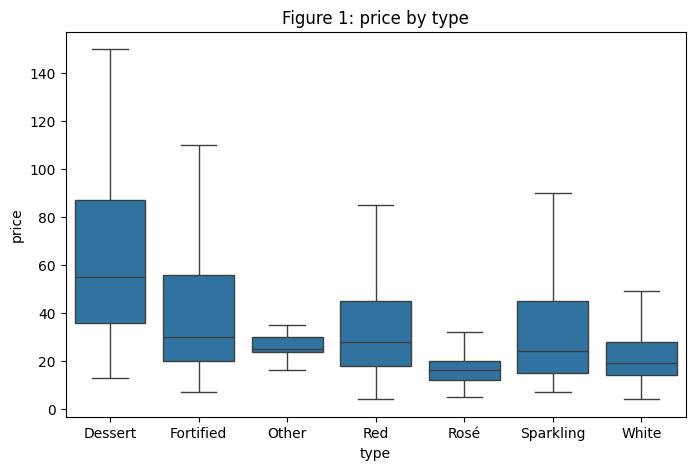

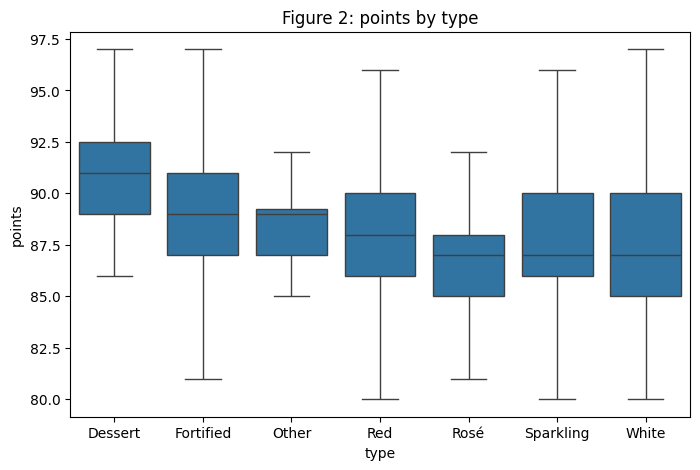

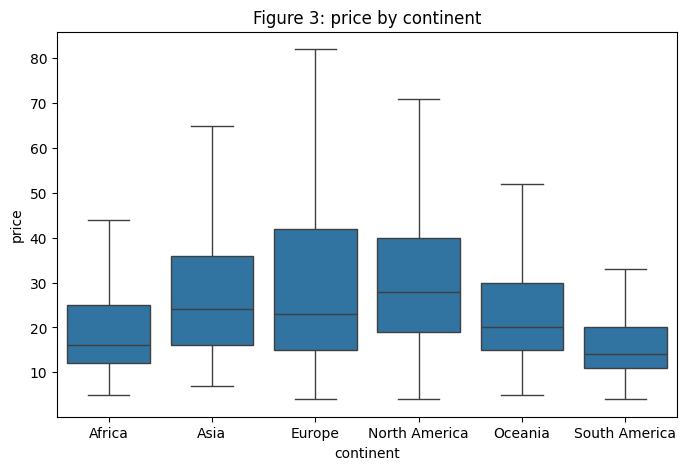

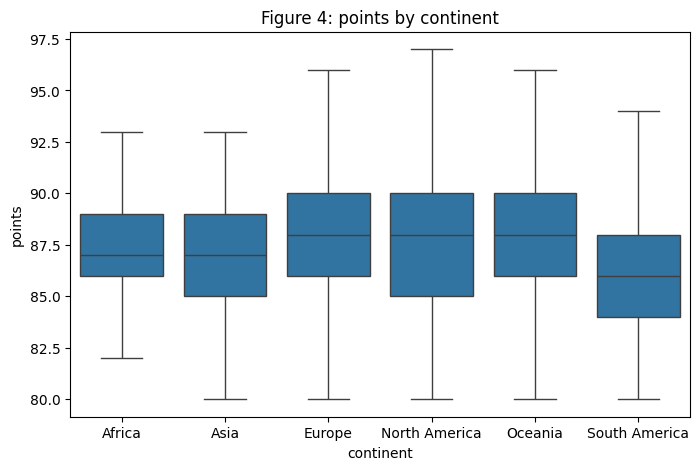

In [95]:
categorical_vars = ['type', 'continent']
numeric_vars = ['price', 'points']
for i, (cat_var, num_var) in enumerate(product(categorical_vars, numeric_vars), start=1):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=cat_var, y=num_var, data=wines, showfliers=False)
    plt.title(f"Figure {i}: {num_var} by {cat_var}")
    plt.show()

## Statistically testing for correlation between numeric and categorical variables

In [96]:
results_summary = []

for cat_var in categorical_vars:
    for num_var in numeric_vars:

        data = wines[[cat_var, num_var]].copy()

        # Preparing the data and checking skewness
        skew_val = skew(data[num_var].dropna())
        if abs(skew_val) > 1:
            data[num_var] = np.log1p(data[num_var])
            transform_note = f'Applied log-transform due to skewness = {skew_val:.2f}'
        else:
            transform_note = 'No transformation applied'
        # Grouping the data
        grouped = [g[num_var].values for name, g in data.groupby(cat_var)]

        # Testing ANOVA assumptions
        # a) Normality within groups
        normal = True
        for name, g in data.groupby(cat_var):
            stat, p = shapiro(g[num_var])
            if p < 0.05:
                normal = False
        # b) Homogeneity of variance
        stat, p_var = levene(*grouped)
        equal_var = p_var > 0.05

        # Choosing the correct test
        # a) ANOVA
        if normal and equal_var:
            test_type = 'ANOVA'
            test = pg.anova(dv=num_var, between=cat_var, data=data, detailed=True)
            p_value = test['p-unc'][0]
            posthoc = pairwise_tukeyhsd(endog=data[num_var], groups=data[cat_var], alpha=0.05)
            posthoc_summary = posthoc.summary()
        # b) Welch ANOVA
        elif normal and not equal_var:
            test_type = 'Welch Anova'
            test = pg.welch_anova(dv=num_var, between=cat_var, data=data, detailed=True)
            p_value = test['p-unc'][0]
            posthoc = pairwise_tukeyhsd(endog=data[num_var], groups=data[cat_var], alpha=0.05)
            posthoc_summary = posthoc.summary()
        # c) Kruskal-Wallis
        else:
            test_type = 'Kruskal-Wallis'
            stat_kw, p_value = kruskal(*grouped)
            posthoc_summary = sp.posthoc_dunn(data, val_col=num_var, group_col=cat_var, p_adjust='bonferroni')

        # Interpreting significance
        if p_value < 0.05:
            interpretation = f'There is a statistically significant difference in a wine\'s {num_var} across its {cat_var} (p={p_value:.3g}).'
        else:
            interpretation = f'No statistically significant difference in {num_var} across {cat_var} (p={p_value:.3g}).'

        # Storing the results    
        results_summary.append({
            'Categorical': cat_var,
            'Numeric': num_var,
            'Test': test_type,
            'p-value': p_value,
            'Interpretation': interpretation,
            'Posthoc': posthoc_summary, 
            'Transformation': transform_note
        })

        # Displaying the final results
for res in results_summary:
    print(f'\n--- {res['Numeric']} by {res['Categorical']} ---')
    print(f'Test used: {res['Test']}, p-value = {res['p-value']:.3g}')
    print(res['Transformation'])
    print(res['Interpretation'])


--- price by type ---
Test used: Kruskal-Wallis, p-value = 0
Applied log-transform due to skewness = 11.82
There is a statistically significant difference in a wine's price across its type (p=0).

--- points by type ---
Test used: Kruskal-Wallis, p-value = 1.15e-293
No transformation applied
There is a statistically significant difference in a wine's points across its type (p=1.15e-293).

--- price by continent ---
Test used: Kruskal-Wallis, p-value = 0
Applied log-transform due to skewness = 11.82
There is a statistically significant difference in a wine's price across its continent (p=0).

--- points by continent ---
Test used: Kruskal-Wallis, p-value = 0
No transformation applied
There is a statistically significant difference in a wine's points across its continent (p=0).


C:\Users\sammy\AppData\Local\Temp\ipykernel_19392\3775566514.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = [g[num_var].values for name, g in data.groupby(cat_var)]
C:\Users\sammy\AppData\Local\Temp\ipykernel_19392\3775566514.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, g in data.groupby(cat_var):
C:\Users\sammy\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 86539.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\sammy\AppData\L

## Statistically testing for causality between numeric and categorical variables

In [97]:
# Set up confounders and results storage
all_confounders = ['continent', 'type', 'points', 'price'] # all variables that might influence both the treatment and outcome
results = []

# Define the helper function: propensity_score_matching()
def propensity_score_matching(df, treatment_col, outcome_col, covariates):
    ''' Performs nearest-neighbour propensity score matching and returns the 
    average difference in outcome for the 'treated' group, after matching.'''
        # Takes a datframe 'df' and identifies:
            # treatment_col: the categorical variable (cause)
            # outcome_col: the numeric variable (effect)
            # covariates: the confounders to control for
    # A) Clean the data
    df = df.copy().dropna(subset=[treatment_col, outcome_col] + covariates)
        # Drop missing values for all required columns
        # .copy() to avoid modifying original data
    # B) Encode the treatment as binary
    if df[treatment_col].nunique() > 2:
        vals = df[treatment_col].unique()[:2]
        df = df[df[treatment_col].isin(vals)].copy()
    df['treatment'] = (df[treatment_col] == df[treatment_col].unique()[0]).astype(int)
        # If categorical variables has more than two categories (e.g red, white, rosé) only take first two to make a binary treatment.
        # Then, make a new column:
            # treatment = 1 for the first category (e.g. red)
            # treatment = 0 for the other (e.g. white)
        # PSM require a binary treatment variable
    # C) Prepare the cofounders (X matrix) and treatment (y)
    X = pd.get_dummies(df[covariates], drop_first=True)
    y = df['treatment']
        # X: The confounders matrix - dummy-encoded for categorical variables
        # y: The treatment variable (0 or 1)
    # D) Estimate Propensity Score
    ps_model = LogisticRegression(max_iter=1000).fit(X, y)
    df['pscore'] = ps_model.predict_proba(X)[:, 1]
        # Fit a logistic regression model to predict probability of being a treatment varibales given the confounders.
        # Predicted probability (pscore) is the propensity score:
            # 'Given its covariates, how likely was this wine to be in the treated group (e.g. red wine)?'
        # These scores will be used to find comparable 'matches'
    # E) Separate treated and control groups
    treated = df[df['treatment'] == 1]
    control = df[df['treatment'] == 0]
    # F) Match each treated wine to its closest control wine
    nn = NearestNeighbors(n_neighbors=1).fit(control[['pscore']])
    distances, indices = nn.kneighbors(treated[['pscore']])
    matched_control = control.iloc[indices.flatten()]
    matched = pd.concat([treated, matched_control])
        # For each treated unit (e.g. red wine), find the control (e.g. white wine) with the closest propensity score (i.e. the most similar wine in all relevant aspects except treatment)
        # Creates a 'matched' dataset of comparable pairs
    # G) Estimate the causal effect (ATT)
    att = matched[matched['treatment'] == 1][outcome_col].mean() - matched[matched['treatment'] == 0][outcome_col].mean()
    return att
        # att = average outcome (price or points) of treated wines - average outcome of matched control wines
        # If +ve, then treatment increases the outcome (causal effect)
        # If -ve, then treatment reduces the outcome


# The main causal loop
for cat_var in categorical_vars:
    for num_var in numeric_vars:
        print(f'\nAnalysing causal link between {cat_var} and {num_var}')
        # A) Define valid confounders
        confounders = [c for c in all_confounders if c not in [cat_var, num_var]]
            # Remove treatment and outcome from the confounder list, preventing overadjustment bias (controlling for the variable whose effect you're trying to estimate)
        # B) Prepare data
        df = wines[[cat_var, num_var] + confounders].dropna().copy()
        if df[cat_var].nunique() < 2:
            continue
            # Only keep relevant columns and drop missing data
            # Skip the variable if it only has 1 unique category
        # C) Run the adjusted regression (OLS)
        df['treatment'] = (df[cat_var] == df[cat_var].unique()[0]).astype(int)
        formula = f'{num_var} ~ treatment + ' + ' + '.join(confounders)
        ols_model = smf.ols(formula, data=df).fit()
        coef = ols_model.params['treatment']
        pval = ols_model.pvalues['treatment']
            # Build regression formula like:
                # price ~ treatment + continent + points
            # treatment = binary variable for categorical variable
            # Coefficient (coef) on treatment estimates causal effect of treatment on numeric outcome
            # P-value (pval) tests statistical significance
        # D) Run Propensity Score Matching
        att = propensity_score_matching(df, cat_var, num_var, confounders)
        # E) Store results
        results.append({
            'Categorical Var': cat_var,
            'Numeric Var': num_var,
            'Confounders Used': ', '.join(confounders),
            'OLS Effect': coef,
            'OLS p-value': pval,
            'PSM ATT': att
        })


# Summarise and export results
summary = pd.DataFrame(results)
summary = summary.sort_values(by='OLS p-value', ascending=True)
summary.to_csv('causal_inference_summary_auto_conf.csv', index=False)
print('\nResults saved to \'causal_inference_summary_auto_conf.csv\'')
print('\nSummary of Estimated Causal Effects:')
pd.read_csv('causal_inference_summary_auto_conf.csv')


Analysing causal link between type and price

Analysing causal link between type and points

Analysing causal link between continent and price

Analysing causal link between continent and points

Results saved to 'causal_inference_summary_auto_conf.csv'

Summary of Estimated Causal Effects:


,Categorical Var,Numeric Var,Confounders Used,OLS Effect,OLS p-value,PSM ATT
0,type,price,"continent, points",7.919863,0.000000e+00,8.109014
1,type,points,"continent, price",0.183497,1.178687e-29,-1.550203
2,continent,price,"type, points",0.240251,1.696970e-01,9.635554
3,continent,points,"type, price",0.001863,9.052154e-01,-1.657526


### Does wine type cause differences in price?
##### It is clear to see that, even after controlling for region and WineEnthusiast rating, wine type has a causal impact on price. The summary table aboves shows that certain types are, on average, $8 more expensive, as evidenced by both OLS and PSM scores being around this value (7.92 and 8.11 respectively). The low p-value of 0 also indicates that this effect is highly statistically significant.

### Does wine type cause differences in WineEnthusiast ratings (points)?
##### Ordinary Least Squares regression analysis suggests that there is a small positive causual relationship between wine type and rating, with certain types being rated about 0.18 points higher on average. These findings are backed by the small OLS p-value of 1.18x10^-29, suggesting that this efect is an extremely statistically significant and robust. However, the PSM score of -1.55 contradicts this; wines of the first type actually score about 1.55 points lower than matched wines of other types. This points towards the causal relationship being confounded, where the apparent effect of type on rating maybe due to price differences instead.

### Does a wine's continent of origin affect its price?
##### According to the regression analysis, the continent does not effect price to a great degree, with wines from certain regions only being around 24 cents more expensive on average. However, the large p-value of 0.17 means that these findings are not statistically significant. On the other hand, PSM shows that matching wines from certain continents may cause those wines to be around $9.64 more expensive on average when compared to similar wines of the same type and rating. The results are inconclusive, as regression illutrates there is no significant effect, but Propensity Score Matching suggests there might be one.

### Does a wine's continent of origin affect its WineEnthusiast rating?
##### Referring the summary table, OLS analysis shows a weak and insignifcant causal effect relationship between a wine's geographical origin and rating, as shown by the OLS effect and p-value of 0.002 and 0.905 respectively. Matching similar wines from certain continents also suggests that there is no meaningful effect when compared to that of wines in similar type and price; the PSM ATT value of -1.66 suggests that wines from one continent might score slightly lower, but this discrepancy is insignificant. It would appear that WineEnthusiast reviewers are more inclined to rate wines on its intrinsic qualities, rather than where they came from.


### In conclusion, the findings generated from causal analysis techniques to assess how a wine's characteristics influence its price and ratings were somewhat mixed. 
#### Controlling for external influencing variables, a wine's type was found to have a strong and statistically significant effect on its price, with certain types costing around $8 more on average. 
#### On the other hand, a causal link between a wine's rating and type was less obvious, as the regression and matching results appeared to contradict each other, implying possible confounding. 
#### A wine's continent of origin was shown to be an equally or less significant of an effect on its price and rating, indicating that a wine's geographical region of its own does not causally affect its perceived quality or price after account for its type and rating.